
Data preprocessing        
Output: data/data_final.h5ad

@authors: Melnikas, Max; Nkambule, Lethukuthula; Wan, Guihong        
@date: Oct 12, 2024       

In [88]:
import anndata as ad
import numpy as np
import scimap as sm
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
warnings.filterwarnings("ignore")

## read and process data

In [89]:
if (False): # only run once.
    adata_org = ad.read_h5ad("data/Z147_1_750.h5ad")

In [90]:
print(adata_org.obs_keys)
print(adata_org.obs['phenotype'].value_counts())

<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 1110585 × 30
    obs: 'X_centroid', 'Y_centroid', 'column_centroid', 'row_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'imageid', 'phenotype', 'kmeans', 'kmeans_renamed', 'pickseq_roi', 'pickseq_roi_minimal', 'dermis_roi', 'epidermis_roi', 'general_roi', 'Kmeans_r', 'der_epider_roi', 'phenotype_proliferation', 'phenograph', 'spatial_expression_phenograph', 'spatial_expression_kmeans', 'phenograph_raw', 'phenograph_raw_minimal', 'phenotype_1', 'phenotype_1_tumor_kmeans', 'phenotype_1_tumor_kmeans_renamed', 'phenotype_final', 'spatial_expression_consolidated', 'MC', 'spatial_count_kmeans', 'phenotype_2', 'phenotype_2_tumor_kmeans', 'phenotype_2_tumor_kmeans_renamed', 'phenotype_large_cohort', 'phenotype_large_cohort_RJP', 'spatial_lda_kmeans', 'phenotype_2_tumor_kmeans_old', 'tumor_expression_trimmed', 'tumor_expression_TC', 'IM_roi', 'TC_ROI_IM_large', 

In [91]:
############
# Sampling
############
n_samples = 10000 # Define the number of samples you want
n_obs = adata_org.n_obs # Number of observations (cells) in the dataset
# Ensure the sample size does not exceed the number of available observations
if n_samples > n_obs:
    raise ValueError("Number of samples requested exceeds the number of available observations.")

# Generate random indices for sampling
random_indices = np.random.choice(n_obs, n_samples, replace=False)

# Subset the AnnData object using the random indices
adata = adata_org[random_indices, :]

# Print the shape to confirm the subset process
print(adata.shape)

(10000, 30)


In [92]:
############
# Merge T cells
############

adata.obs['phenotype'] = adata.obs['phenotype'].astype('category')
# T cell categories you want to merge
t_cell_categories = [
    "T cells", "Terminally Exhausted T cells", "Patially Exhausted T cells", 
    "Regulatory T cells", "Cytotoxic T cells"
]
# Update
adata.obs['phenotype'] = adata.obs['phenotype'].replace(t_cell_categories, "T cells")

print(adata.obs['phenotype'].value_counts())

phenotype
Tumor                 4620
Unknown               1571
Myeloid Lineage       1089
Myofibroblast          628
Blood Vessels          539
T cells                506
APCs                   352
Macrophages            295
CD11C+ PDL1+ cells     143
Keratinocytes          140
Melanocytes             70
Mast cells              42
Langerhan cells          5
Name: count, dtype: int64


In [93]:
# First three observations look like
print(adata.obs.head(3))

                        X_centroid    Y_centroid  column_centroid  \
unmicst-1_750_412918   1364.088710  11474.395161      1364.088710   
unmicst-1_750_494109  24418.740157  12534.590551     24418.740157   
unmicst-1_750_19092   14071.886364   1341.500000     14071.886364   

                      row_centroid  Area  MajorAxisLength  MinorAxisLength  \
unmicst-1_750_412918  11474.395161   372        24.014316        19.865139   
unmicst-1_750_494109  12534.590551   127        15.629538        10.625429   
unmicst-1_750_19092    1341.500000   132        14.430581        11.725660   

                      Eccentricity  Solidity    Extent  ...  \
unmicst-1_750_412918      0.561877  0.956298  0.708571  ...   
unmicst-1_750_494109      0.733370  0.940741  0.622549  ...   
unmicst-1_750_19092       0.582883  0.949640  0.733333  ...   

                      phenotype_large_cohort_RJP spatial_lda_kmeans  \
unmicst-1_750_412918               Keratinocytes                  1   
unmicst-1_750_4

In [94]:
# Data Shape
adata[list(adata.obs_names),:].X.shape

(10000, 30)

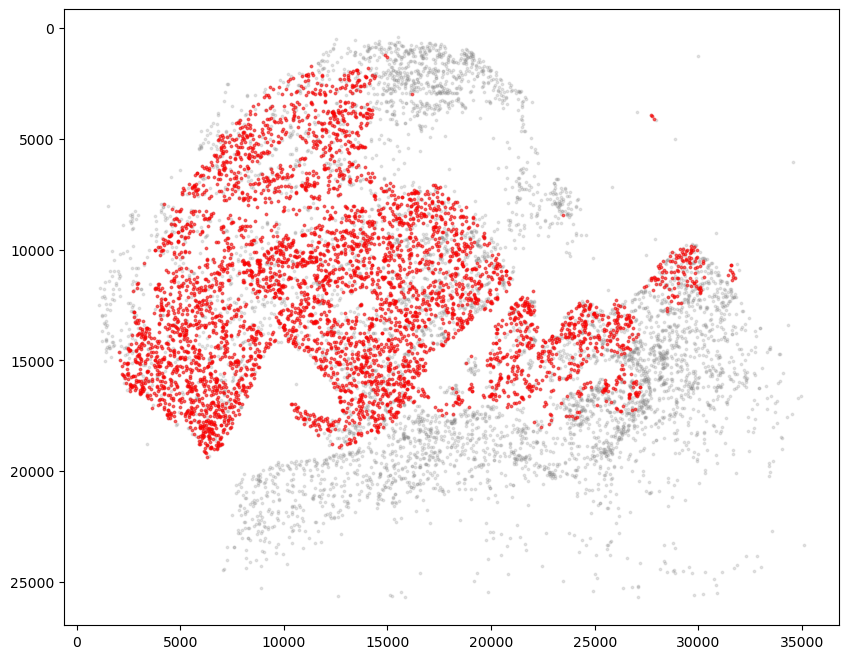

In [95]:
# Plot

fig, ax = plt.subplots(figsize=(10, 8))
# All cells shown in grey for background
ax.scatter(
    *zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()),
    s=3,
    color="grey",
    alpha=0.2
)
# tumor cells
ax.scatter(
    *zip(*adata[adata.obs["phenotype"] == "Tumor"].obs[["X_centroid", "Y_centroid"]].to_numpy()),
    s=3,
    color="red",
    alpha=0.5
)

ax.invert_yaxis()

### Clustering
#### Leiden Clustering

In [96]:
adata = sm.tl.cluster(adata, method='leiden', resolution=0.3, use_raw=False, log=False)
adata.obs['leiden'].value_counts()

Leiden clustering


leiden
0    4734
1    2170
2    1985
3     851
4     179
5      81
Name: count, dtype: int64

#### KMean Clustering

In [121]:
adata = sm.tl.cluster(adata, method='kmeans', k=6, use_raw=False, log=False)
adata.obs['kmeans'].value_counts()

Kmeans clustering


kmeans
1    4804
3    1245
5    1215
0    1102
2     945
4     689
Name: count, dtype: int64

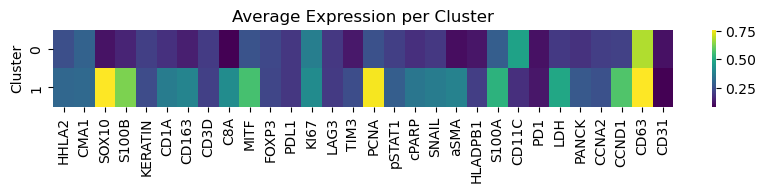

In [102]:
cluster_method = "kmeans"
cluster_of_interest = ['0','1']

adata_cluster = adata[adata.obs[cluster_method].isin(cluster_of_interest)]
cluster_means = adata_cluster.to_df().groupby(adata_cluster.obs[cluster_method]).mean()

plt.figure(figsize=(10, 0.5*len(cluster_of_interest)))
sns.heatmap(cluster_means, cmap='viridis', robust=True)
plt.title("Average Expression per Cluster")
plt.ylabel("Cluster")
plt.show()


### Dimension Reduction

#### UMAP

In [100]:
# Basic UMAP reduction
adata = sm.tl.umap(adata, n_neighbors=15, min_dist=0.1)
adata

AnnData object with n_obs × n_vars = 10000 × 30
    obs: 'X_centroid', 'Y_centroid', 'column_centroid', 'row_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'imageid', 'phenotype', 'kmeans', 'kmeans_renamed', 'pickseq_roi', 'pickseq_roi_minimal', 'dermis_roi', 'epidermis_roi', 'general_roi', 'Kmeans_r', 'der_epider_roi', 'phenotype_proliferation', 'phenograph', 'spatial_expression_phenograph', 'spatial_expression_kmeans', 'phenograph_raw', 'phenograph_raw_minimal', 'phenotype_1', 'phenotype_1_tumor_kmeans', 'phenotype_1_tumor_kmeans_renamed', 'phenotype_final', 'spatial_expression_consolidated', 'MC', 'spatial_count_kmeans', 'phenotype_2', 'phenotype_2_tumor_kmeans', 'phenotype_2_tumor_kmeans_renamed', 'phenotype_large_cohort', 'phenotype_large_cohort_RJP', 'spatial_lda_kmeans', 'phenotype_2_tumor_kmeans_old', 'tumor_expression_trimmed', 'tumor_expression_TC', 'IM_roi', 'TC_ROI_IM_large', 'TC_ROI_IM_small', 'TC_ROI_IM_elarge

#### t-SNE

In [101]:
sc.tl.tsne(adata)
adata

AnnData object with n_obs × n_vars = 10000 × 30
    obs: 'X_centroid', 'Y_centroid', 'column_centroid', 'row_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'imageid', 'phenotype', 'kmeans', 'kmeans_renamed', 'pickseq_roi', 'pickseq_roi_minimal', 'dermis_roi', 'epidermis_roi', 'general_roi', 'Kmeans_r', 'der_epider_roi', 'phenotype_proliferation', 'phenograph', 'spatial_expression_phenograph', 'spatial_expression_kmeans', 'phenograph_raw', 'phenograph_raw_minimal', 'phenotype_1', 'phenotype_1_tumor_kmeans', 'phenotype_1_tumor_kmeans_renamed', 'phenotype_final', 'spatial_expression_consolidated', 'MC', 'spatial_count_kmeans', 'phenotype_2', 'phenotype_2_tumor_kmeans', 'phenotype_2_tumor_kmeans_renamed', 'phenotype_large_cohort', 'phenotype_large_cohort_RJP', 'spatial_lda_kmeans', 'phenotype_2_tumor_kmeans_old', 'tumor_expression_trimmed', 'tumor_expression_TC', 'IM_roi', 'TC_ROI_IM_large', 'TC_ROI_IM_small', 'TC_ROI_IM_elarge

In [103]:
print(adata.obsm["X_tsne"].shape)
print(adata.obsm["umap"].shape)

(10000, 2)
(10000, 2)


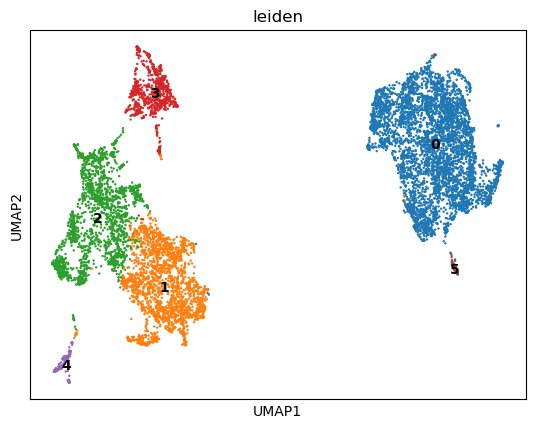

In [104]:
sc.pl.umap(adata, color='leiden', legend_loc='on data')

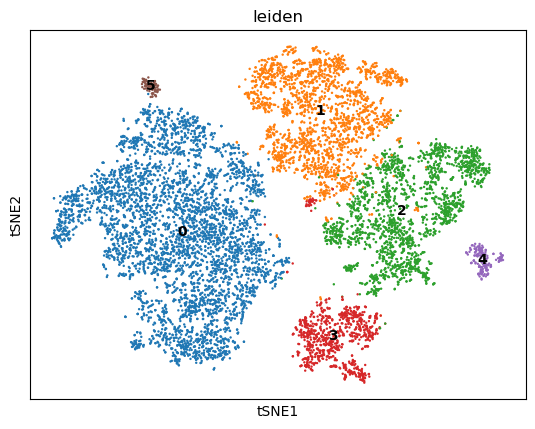

In [105]:
sc.pl.tsne(adata, color='leiden', legend_loc='on data')

In [122]:
adata.write("data/data_final.h5ad")